In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.sparse import csc_array

import matplotlib.pyplot as plt
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

from qs_mps.applications.Z2.exact_hamiltonian import *
from qs_mps.sparse_hamiltonians_and_operators import diagonalization, sparse_magnetization, sparse_pauli_x, sparse_pauli_z
from qs_mps.mps_class import MPS

model = "Z2_dual"
bc = "pbc"
path = "/Users/fradm/Desktop/projects/1_Z2"
path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
L = 70
N = 4
d = 2**N
chi = 64
g = 0.8
R = 0
cx = get_cx(L, R)
cy = get_cy(N, bc, R=R)
cx = np.nan
cy = np.nan

lattice = MPS(L=L, d=d, model=model, chi=chi, h=g, bc=bc)
if R != 0:
    lattice.Z2.add_charges(cx,cy)
    lattice.Z2._define_sector()
lattice.load_sites(path, precision=3, cx=cx, cy=cy)

Metadata: {'L': 70, 'bc': 'pbc', 'chi': 128, 'cx': nan, 'cy': nan, 'h': 0.8, 'l': 4, 'model': 'Z2_dual', 'sector': 'vacuum_sector'}


In [ ]:
mps_tm_1site = ncon([lattice.sites[L//2].conjugate(), lattice.sites[L//2]], [[-1,1,-3],[-2,1,-4]])
matrix_1site = mps_tm_1site.reshape((lattice.sites[L//2].shape[0]**2,lattice.sites[L//2].shape[2]**2))

e1, v1 = diagonalization(matrix_1site, sparse=True, k=2, which='LA')

In [ ]:
e1

array([-0.76165806, -0.62821076])

In [ ]:
xi = - 1/np.log(abs(e1[0]))

## generalize to multiple sites TM

In [24]:
def multi_site_mps_transfer_matrix(sites, mps_tm: np.ndarray=None):
    tensors_idxs = [L//2-sites//2+i for i in range(sites)]

    if mps_tm is None:
        mps_tm = ncon([lattice.sites[tensors_idxs[0]].conjugate(), lattice.sites[tensors_idxs[0]]], [[-1,1,-3],[-2,1,-4]])
    else:
        mps_tm = mps_tm.reshape((lattice.sites[tensors_idxs[0]].shape[0],lattice.sites[tensors_idxs[0]].shape[0],lattice.sites[tensors_idxs[-1]].shape[2],lattice.sites[tensors_idxs[-1]].shape[2]))
        if (sites % 2) == 0:
            mps_tm = ncon([lattice.sites[tensors_idxs[0]].conjugate(), mps_tm], [[-1,-2,1], [1,-3,-4,-5]])
            mps_tm = ncon([lattice.sites[tensors_idxs[0]], mps_tm], [[-2,1,2],[-1,1,2,-3,-4]])
        elif (sites % 2) == 1:
            mps_tm = ncon([mps_tm, lattice.sites[tensors_idxs[-1]].conjugate()], [[-1,-2,1,-5],[1,-4,-3]])
            mps_tm = ncon([mps_tm, lattice.sites[tensors_idxs[-1]]], [[-1,-2,-3,1,2],[2,1,-4]])

    transfer_matrix = mps_tm.reshape((lattice.sites[tensors_idxs[0]].shape[0]**2,lattice.sites[tensors_idxs[-1]].shape[2]**2))
    return transfer_matrix

In [25]:
sites = 1
tm = multi_site_mps_transfer_matrix(sites)

In [26]:
e1, v1 = diagonalization(tm, sparse=True, k=3)

In [27]:
e1

array([-0.04695732, -0.03025869, -0.03000255])

In [28]:
energies = []
end = 4
tm = None
for sites in range(1,end):
    print(f"computing a {sites} site(s) transfer matrix...")
    tm = multi_site_mps_transfer_matrix(sites, mps_tm=tm)
    print(f"transfer matrix found. Shape is {tm.shape}")
    e1, v1 = diagonalization(tm, sparse=True, k=2, which='LA')
    energies.append(e1)

computing a 1 site(s) transfer matrix...
transfer matrix found. Shape is (16384, 16384)
computing a 2 site(s) transfer matrix...
transfer matrix found. Shape is (16384, 16384)
computing a 3 site(s) transfer matrix...
transfer matrix found. Shape is (16384, 16384)


In [29]:
np.asarray(energies).shape

(3, 2)

In [30]:
corr_lens = np.array([-(i+1)/np.log(np.abs(np.asarray(energies)[i,1])) for i in range(len(energies))])

In [33]:
h_i, h_f, npoints = 0.6, 1.0, 21
if R == 0:
    sector = "vacuum_sector"
    try:
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        h_i, h_f, npoints = 0.6, 1.0, 9
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_nan-nan_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    except:
        e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
        e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
else:
    sector = "2_particle(s)_sector"
    e0_mps = np.load(f"{path}/results/energy_data/energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    e1_mps = np.load(f"{path}/results/energy_data/first_excited_energy_{model}_direct_lattice_{N}x{L}_{sector}_bc_{bc}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fradm/Desktop/projects/1_Z2/results/energy_data/energy_Z2_dual_direct_lattice_4x70_vacuum_sector_bc_pbc_None-None_h_0.6-1.0_delta_9_chi_128.npy'

In [ ]:
vs = (e1_mps - e0_mps)[4] * corr_lens

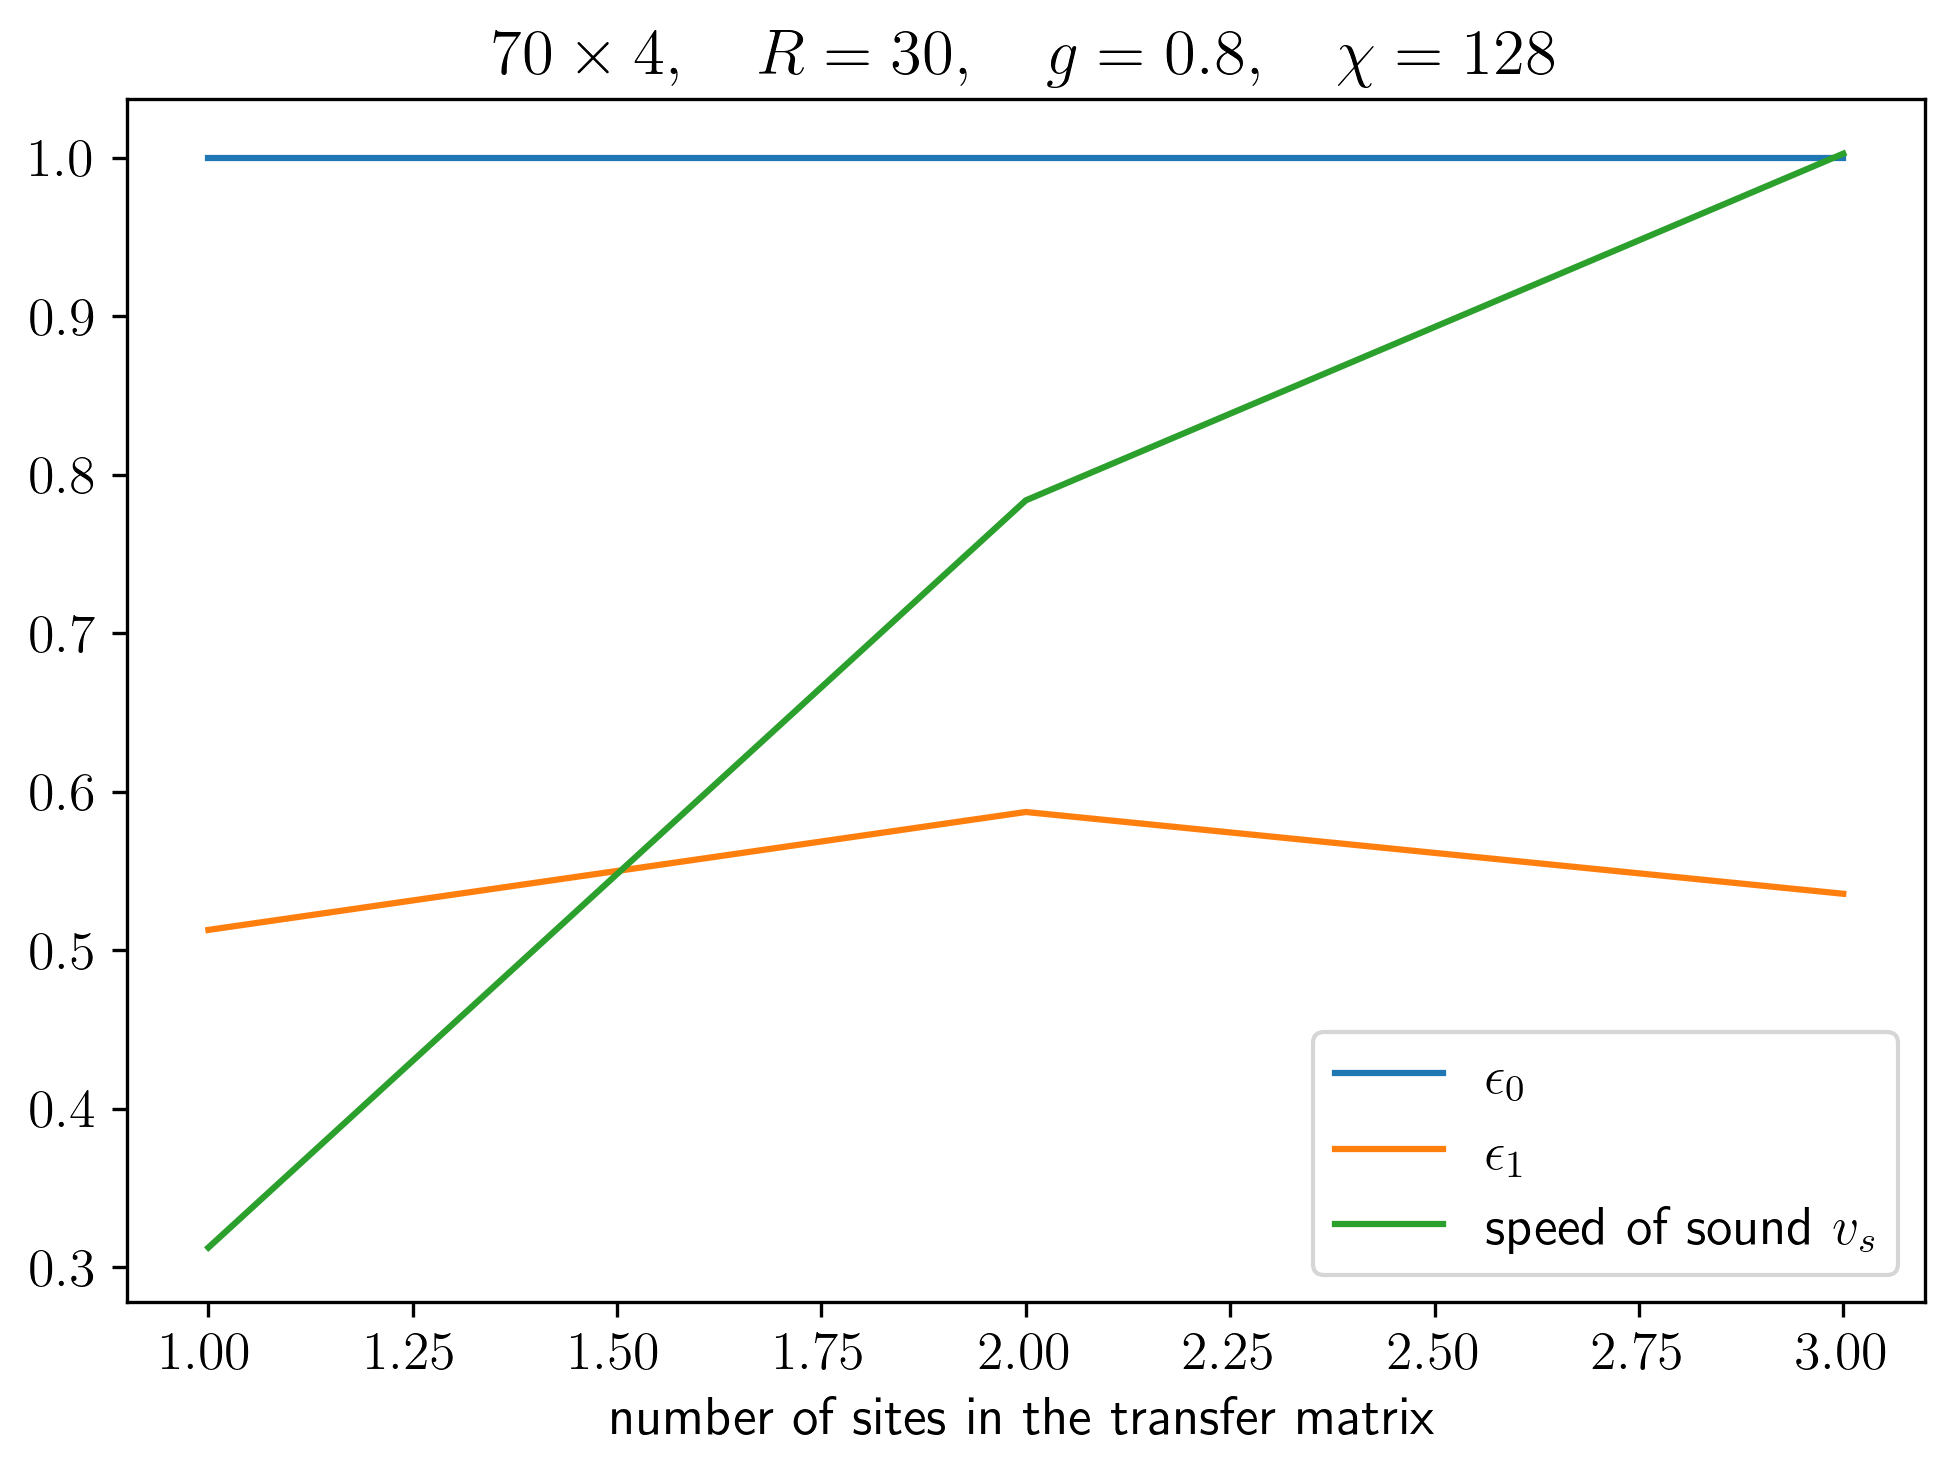

In [ ]:
plt.plot(range(1,len(vs)+1), np.abs(np.asarray(energies)[:,0]), label="$\epsilon_0$")
plt.plot(range(1,len(vs)+1), np.abs(np.asarray(energies)[:,1]), label="$\epsilon_1$")
plt.plot(range(1,len(vs)+1), vs, label="speed of sound $v_s$")
plt.xlabel("number of sites in the transfer matrix")
plt.title(f"${L}\\times{N}, \\quad R={R}, \\quad g={g}, \\quad \\chi={chi}$")
plt.legend()
plt.savefig(f"{path_figures}/figures/energy/speed_of_sound_{N}x{L}_R_{R}_g_{g}_chi_{chi}.png")